In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
import math
from tqdm import tqdm

# Algorithm 1. GEM-Based Real-Time Nonparametric Anomaly Detection

## Offline Phase

In [2]:
df = pd.read_csv('data.csv')
df.head(5)

,SampleTime,SensorID,Value
0,0,2,0.033883
1,0,4,-0.009496
2,0,5,0.000000
3,0,7,-0.057306
4,0,8,0.029096


count    4.496620e+06
mean     7.463843e-04
std      2.288528e-02
min     -7.197240e-01
25%     -7.435000e-03
50%      2.900000e-04
75%      8.535000e-03
max      3.012097e+00
Name: Value, dtype: float64


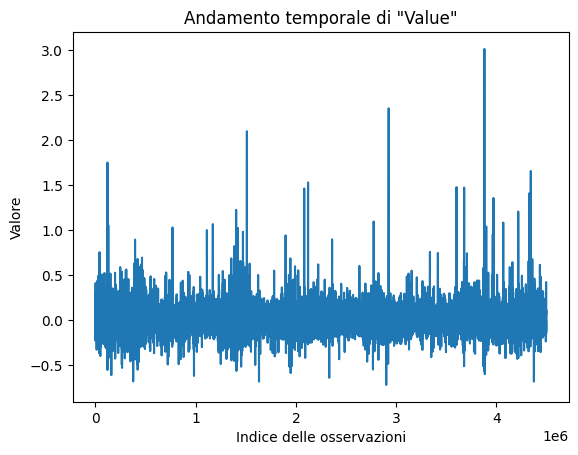

Anomalie rilevate:
Empty DataFrame
Columns: [SampleTime, SensorID, Value]
Index: []


In [3]:
# 1. Esegui una rapida esplorazione del tuo dataset
print(df['Value'].describe())

# 2. Visualizza l'andamento temporale della colonna "Value"
plt.plot(df['Value'])
plt.xlabel('Indice delle osservazioni')
plt.ylabel('Valore')
plt.title('Andamento temporale di "Value"')
plt.show()

# 3. Calcolo delle statistiche di base
mean_baseline = df['Value'].mean()
std_baseline = df['Value'].std()

# 4. Rilevamento delle anomalie con Isolation Forest
X = df['Value'].values.reshape(-1, 1)
clf = IsolationForest(contamination=0.0001)  # Modifica la contaminazione in base alle tue esigenze
clf.fit(X)

# Identificazione delle anomalie
predictions = clf.predict(X)
anomalies= df[predictions == -1]
anomalies_index = df.index[predictions == -1]

print("Anomalie rilevate:")
print(anomalies)

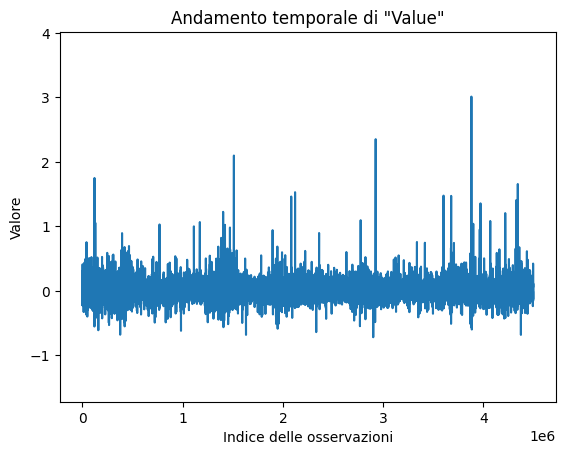

In [4]:
# Rimozione delle anomalie dal dataframe originale
df_cleaned = df.drop(anomalies_index)

# Grafico dopo la rimozione delle anomalie
plt.plot(df_cleaned['Value'])
plt.xlabel('Indice delle osservazioni')
plt.ylabel('Valore')
plt.title('Andamento temporale di "Value"')

# Impostazione dei limiti dell'asse y per allargarlo
plt.ylim(bottom=df_cleaned['Value'].min() - 1, top=df_cleaned['Value'].max() + 1)

plt.show()


In [5]:
# Calcolare il numero di righe da eliminare
num_righe_da_elim = int(len(df_cleaned) // 1.017)

# Selezionare in modo casuale le righe da eliminare
righe_da_elim = np.random.choice(df_cleaned.index, num_righe_da_elim, replace=False)

# Eliminare le righe selezionate
df_reduced = df_cleaned.drop(righe_da_elim)


# Numero totale di punti nel dataset
N = len(df_reduced)

print("Dimensione di N:", N)

# Definisci le dimensioni dei due sottoinsiemi, N1 e N2
N1 = N // 2  # Arrotonda alla parte intera più vicina
N2 = N - N1

# Genera un array di indici casuali unici per selezionare i punti per S1
indices = np.random.permutation(N)
indices_S1 = indices[:N1]

# Seleziona i punti corrispondenti a questi indici per formare S1
S1 = df_reduced.iloc[indices_S1]

# Seleziona i punti rimanenti per formare S2
S2 = df_reduced.iloc[indices[N1:]]

# Stampa le dimensioni dei due sottoinsiemi
print("Dimensione di S1:", len(S1))
print("Dimensione di S2:", len(S2))

Dimensione di N: 75165
Dimensione di S1: 37582
Dimensione di S2: 37583


In [6]:
# Seleziona le colonne appropriate da utilizzare per il calcolo delle distanze
features = ['SensorID', 'Value']  # Ad esempio, seleziona le colonne 'SensorID' e 'Value'

def compute_dj(xj, S1, k):
    # Seleziona solo le feature rilevanti per il calcolo delle distanze
    S1_features = S1[features].values
    
    # Trova i kNN di xj in S1
    nbrs = NearestNeighbors(n_neighbors=k, algorithm='ball_tree').fit(S1_features)
    distances, indices = nbrs.kneighbors([xj[features]])
    
    # Calcola la somma delle distanze euclidee di xj ai suoi kNN
    dj = np.sum(distances)
    return dj

In [7]:
# Definisci la funzione per calcolare la distanza euclidea tra due punti
def euclidean_distance(x1, x2):
    return np.linalg.norm(x1 - x2)

# Inizializza una lista per memorizzare i valori di dj
d_values = []

k = 10

# Inizializza una barra di avanzamento con il numero totale di punti in S2
with tqdm(total=len(S2)) as pbar:
    # Itera su ciascun punto xj in S2
    for index, xj in S2.iterrows():
        # Inizializza una lista per memorizzare le distanze euclidee di xj dai suoi kNN in S1
        distances_xj = []
        
        # Cerca i kNN di xj tra i punti in S1
        for _, xi in S1.iterrows():
            # Calcola la distanza euclidea tra xj e xi
            distance = euclidean_distance(xj, xi)
            # Aggiungi la distanza alla lista delle distanze per xj
            distances_xj.append(distance)
        
        # Ordina le distanze e seleziona solo i primi k valori
        kNN_distances = sorted(distances_xj)[:k]
        
        # Calcola dj sommando le distanze dei kNN
        dj = sum(kNN_distances)
        
        # Aggiungi dj alla lista dei valori di dj
        d_values.append(dj)

        # Aggiorna la barra di avanzamento di una unità
        pbar.update(1)

  0%|          | 7/37583 [00:16<24:22:16,  2.33s/it]


KeyboardInterrupt: 

## Online Detection Phase

In [72]:
# Inizializzazione
t = 0
gt = 0
h = 10
k = 10
a = 0.01

# Inizializzazione della barra di avanzamento
progress_bar = tqdm(total=len(df), desc="Processing")

while gt < h:

    # Ottenimento del nuovo punto dati xt
    if t < len(df):
        xt = df.iloc[t]["Value"]

        distances_xj = []
        for _, xi in S1.iterrows():
            distance = euclidean_distance(xt, xi)
            distances_xj.append(distance)
        
        # Ordina le distanze e seleziona solo i primi k valori
        kNN_distances = sorted(distances_xj)[:k]
        
        # Calcola dt sommando le distanze dei kNN
        dt = sum(kNN_distances)

        # Calcola pt
        pt = 0
        for _, xj in S2.iterrows():
            distances_xj = []
            for _, xi in S1.iterrows():
                distance = euclidean_distance(xj, xi)
                distances_xj.append(distance)
            
            # Ordina le distanze e seleziona solo i primi k valori
            kNN_distances = sorted(distances_xj)[:k]
            
            # Calcola dj come la somma delle distanze ai kNN
            dj = sum(kNN_distances)
            
            if dj > dt:
                pt += 1
        
        pt /= N2  # Dividi per N2 per ottenere pt

        # Calcola st
        if pt != 0:  # Assicurati di non dividere per zero
            st = math.log(a / pt)  # Calcolo di st utilizzando il logaritmo naturale
        else:
            st = float('inf')  # Se pt è zero, st sarà infinito

        # Calcola gt utilizzando la formula gt = max(0, g_{t-1} + st)
        gt = max(0, gt + st)

        # Incrementa t
        t += 1

        # Aggiorna la barra di avanzamento
        progress_bar.update(1)

        # Stampare l'ultimo valore xt
        print("Ultimo valore di xt:", xt)

# Fine del ciclo while
progress_bar.close()  # Chiude la barra di avanzamento quando il ciclo è completato

Processing:   0%|          | 0/4496620 [48:56<?, ?it/s]


KeyboardInterrupt: 

# Algorithm 2. PCA-Based Real-Time Nonparametric Anomaly Detection

## Offline Phase

In [8]:
# Numero totale di punti nel dataset
N = len(df_cleaned)

# Definisci le dimensioni dei due sottoinsiemi, N1 e N2
N1 = N // 2  # Arrotonda alla parte intera più vicina
N2 = N - N1

# Genera un array di indici casuali unici per selezionare i punti per S1
indices = np.random.permutation(N)
indices_S1 = indices[:N1]

# Seleziona i punti corrispondenti a questi indici per formare S1
S1 = df_cleaned.iloc[indices_S1]

# Seleziona i punti rimanenti per formare S2
S2 = df_cleaned.iloc[indices[N1:]]

# Stampa le dimensioni dei due sottoinsiemi
print("Dimensione di S1:", len(S1))
print("Dimensione di S2:", len(S2))

Dimensione di S1: 2248310
Dimensione di S2: 2248310


In [9]:
# Calcola la media dei punti in S1 (x bar)
x_bar = np.mean(S1, axis=0)
x_bar

SampleTime    3280.260472
SensorID       502.242961
Value            0.000742
dtype: float64

In [10]:
# Calcola il numero di punti in S1 (N1)
N1 = len(S1)

# Inizializza la matrice Q come matrice di zeri
Q = np.zeros((len(S1.columns), len(S1.columns)))

# Calcola la matrice di covarianza Q
for index, xi in S1.iterrows():
    xi_diff = xi - x_bar
    Q += np.outer(xi_diff, xi_diff)

# Normalizza Q dividendo per N1
Q /= N1
Q

array([[ 2.92499831e+06, -1.22150829e+03, -9.05125932e-02],
       [-1.22150829e+03,  8.19035548e+04, -2.14184814e-04],
       [-9.05125932e-02, -2.14184814e-04,  5.22897379e-04]])

In [11]:
# Calcola gli autovalori e gli autovettori della matrice di covarianza Q
eigenvalues, eigenvectors = np.linalg.eigh(Q)

# Stampa gli autovalori e gli autovettori
print("Autovalori:", eigenvalues)
print("Autovettori:")
for i, v in enumerate(eigenvectors.T):
    print("Autovettore", i+1, ":", v)

Autovalori: [5.22894578e-04 8.19030300e+04 2.92499884e+06]
Autovettori:
Autovettore 1 : [3.09457790e-08 3.07661055e-09 1.00000000e+00]
Autovettore 2 : [ 4.29640254e-04  9.99999908e-01 -3.08990582e-09]
Autovettore 3 : [-9.99999908e-01  4.29640254e-04  3.09444543e-08]


In [12]:
# Definisci il livello desiderato di gamma (fra i valori 0 e 1)
desired_gamma = 0.95  # Ad esempio, se desideri mantenere il 95% della varianza, puoi impostare questo valore su 0.95

# Calcola la frazione di varianza mantenuta
cumulative_variance_ratio = np.cumsum(eigenvalues) / np.sum(eigenvalues)

# Trova il valore più piccolo di r che soddisfi la condizione
r = np.argmax(cumulative_variance_ratio >= desired_gamma) + 1

# Forma la matrice V contenente gli autovettori corrispondenti ai r autovalori più grandi
V = eigenvectors[:, :r]

# Stampa r e la matrice V
print("Dimensione della sottomanifattura (r):", r)
print("Matrice V (contenente gli autovettori):")
print(V)

Dimensione della sottomanifattura (r): 3
Matrice V (contenente gli autovettori):
[[ 3.09457790e-08  4.29640254e-04 -9.99999908e-01]
 [ 3.07661055e-09  9.99999908e-01  4.29640254e-04]
 [ 1.00000000e+00 -3.08990582e-09  3.09444543e-08]]


In [13]:
# Calcola la media dei punti in S2 (x bar)
x_bar = np.mean(S2["Value"], axis=0)
x_bar

0.0007506606139722725

In [14]:
# Lista per memorizzare le norme ||r_j||_2
norms_rj = []

I = np.eye(len(S2.columns))

# Per ogni punto xj in S2
for index, xj in S2.iterrows():

    xj = xj["Value"]

    # Calcola rj come indicato nell'equazione
    rj = np.dot(I - np.dot(V, V.T), (xj - x_bar))
    
    # Calcola la norma euclidea di rj
    norm_rj = np.linalg.norm(rj)
    
    # Aggiungi la norma di rj alla lista delle norme
    norms_rj.append(norm_rj)

# Stampa le prime 5 norme ||r_j||_2
for j in range(5):
    print("Norma di r_{}: {}".format(j + 1, norms_rj[j]))

Norma di r_1: 7.305816610296956e-18
Norma di r_2: 3.8053899649954835e-17
Norma di r_3: 1.508327410790424e-17
Norma di r_4: 1.802224442092345e-17
Norma di r_5: 6.5510990892618535e-18


In [15]:
# Ordina le norme ||r_j||_2 in ordine crescente
sorted_norms = sorted(norms_rj)

# Stampa la norma maggiore e minore
print(sorted_norms[0], sorted_norms[-1])

3.3911476606778424e-22 2.349411019473551e-15


## Online Detection Phase

In [32]:
window_size = 100  # Dimensione della finestra scorrevole

# Funzione per aggiornare la finestra scorrevole
def update_window(window, new_point):
    if len(window) >= window_size:
        window.pop(0)
    window.append(new_point)

In [33]:
# Funzione per addestrare il PCA sulla finestra corrente
def train_pca(window):
    pca = PCA()
    pca.fit(np.array(window).reshape(-1, 1))  # Adatta il modello PCA alla finestra corrente
    return pca

In [34]:
# Inizializzazione
t = 0
gt = 0
gt_threshold = None
xt_threshold = None
window = []  # Lista per memorizzare i dati nella finestra scorrevole
h = 10  # Soglia per rilevare un'anomalia
a = 0.01  # Parametro per il calcolo di st


# Ciclo while per l'online detection
with tqdm(total=len(df)) as pbar:  # Inizializza la barra di avanzamento con la lunghezza totale del DataFrame
    while gt < h and t < len(df):

        # Incremento di t
        t += 1

        # Ottenimento del nuovo punto dati xt
        xt = df.iloc[t - 1]["Value"]

        # Aggiungi il nuovo punto alla finestra scorrevole
        update_window(window, xt)

        # Solo addestrare il modello se abbiamo abbastanza dati nella finestra
        if len(window) >= window_size:
            # Calcola il punto medio della finestra x_bar
            x_bar = np.mean(window)

            # Calcola i vettori principali della finestra V utilizzando PCA
            pca = train_pca(window)
            V = pca.components_.T  # Vettori principali della finestra

            # Calcola la differenza tra xt e il punto medio x_bar
            xt_minus_xbar = xt - x_bar

            # Proietta la differenza nello spazio ortogonale a V
            I = np.eye(len(V))  # Matrice identità della stessa dimensione dei vettori principali
            rt = np.dot(I - np.dot(V, V.T), xt_minus_xbar)

            # Calcola la norma euclidea di rt
            norm_rt = np.linalg.norm(rt)

            # Calcolo di pt
            sorted_norms = sorted([np.linalg.norm(np.dot(I - np.dot(V, V.T), x - x_bar)) for x in window])
            pt = sum(1 for norm_rj in sorted_norms if norm_rt < norm_rj) / len(window)

            if pt == 0:
                pt = 1e-50  # Assicurati che pt non sia zero

            # Calcola st
            st = math.log(a / pt)

            # Calcola il nuovo valore di gt
            gt = max(0, gt + st)

            # Controllo se gt supera o raggiunge h
            if gt >= h and gt_threshold is None:
                gt_threshold = gt  # Salva il valore di gt quando gt >= h
                xt_threshold = xt  # Salva il valore di xt corrispondente

        # Aggiornamento della barra di avanzamento
        pbar.update(1)

# Stampa il valore di gt quando gt >= h
if gt_threshold is not None:
    print("Il valore di xt corrispondente è:", xt_threshold)
else:
    print("Nessun valore di gt supera o raggiunge h durante il ciclo.")


  0%|          | 10000/4496620 [00:00<02:23, 31270.23it/s]

Il valore di xt corrispondente è: -0.003329


In [134]:
# Inizializzazione
t = 0
gt = 0
h = 9  # Esempio di soglia
a = 0.01  # Esempio di valore di a

# Inizializzazione delle variabili per memorizzare i valori di gt e xt quando gt >= h
gt_threshold = None
xt_threshold = None

# Calcola il punto medio della sottomanifattura x_bar
x_bar = df["Value"].mean()

# Calcola i vettori principali della sottomanifattura V utilizzando PCA
pca = PCA()
pca.fit(df)  # Adatta il modello PCA al dataset
V = pca.components_.T  # Vettori principali della sottomanifattura

# Ciclo while per l'online detection
with tqdm(total=len(df)) as pbar:  # Inizializza la barra di avanzamento con la lunghezza totale del DataFrame
    while gt < h:

        # Ottenimento del nuovo punto dati xt
        if t < len(df):
            xt = df.iloc[t]["Value"]

            # 1. Calcola la differenza tra xt e il punto medio x_bar della sottomanifattura
            xt_minus_xbar = xt - x_bar

            # 2. Proietta la differenza nello spazio ortogonale a V
            rt = np.dot(I - np.dot(V, V.T), xt_minus_xbar)

            # 3. Calcola la norma euclidea di rt
            norm_rt = np.linalg.norm(rt)

            # Inizializzazione di pt
            pt = 0

            # Calcolo di pt
            for norm_rj in sorted_norms:
                # Calcola il termine indicatore IF
                if norm_rt < norm_rj:
                    indicator = 1
                else:
                    indicator = 0

                # Aggiungi il valore di IF alla somma
                pt += indicator

            # Divide per N2 per ottenere pt
            pt /= len(S2)

            if pt == 0:
                pt = pt = 1e-50

            # Calcola st
            st = math.log(a / pt)

            # Calcola il nuovo valore di g_t
            gt = max(0, gt + st)

            # Controllo se gt supera o raggiunge h
            if gt >= h and gt_threshold is None:
                gt_threshold = gt  # Salva il valore di gt quando gt >= h
                xt_threshold = xt  # Salva il valore di xt corrispondente

            # Incremento di t
            t += 1

            # Aggiornamento della barra di avanzamento
            pbar.update(1)

        else:
            # Termina il ciclo se abbiamo esaminato tutti i dati nel dataset
            break

# Stampa il valore di gt quando gt >= h
if gt_threshold is not None:
    print("Il valore di xt corrispondente è:", xt_threshold)
else:
    print("Nessun valore di gt supera o raggiunge h durante il ciclo.")

  0%|          | 2791/4496620 [09:54<265:53:52,  4.69it/s]

Il valore di xt corrispondente è: 0.411765
